# Aumentando las probabilidades en el problema de Monty Hall con computación Cuántica

## Creando el algoritmo

In [17]:
from qiskit import QuantumCircuit,execute,transpile
import numpy as np
from qiskit_aer import Aer,AerSimulator
from qiskit.visualization import plot_histogram
qc = QuantumCircuit(3,3)

Nuestro algoritmo de resolución se ejecuta sobre una cadena de 3 qubits. Primero,se debe generar un submodulo que genere el estado $W$ entre los qubits para representar las posibles elecciones de puertas.

VERSION 1:


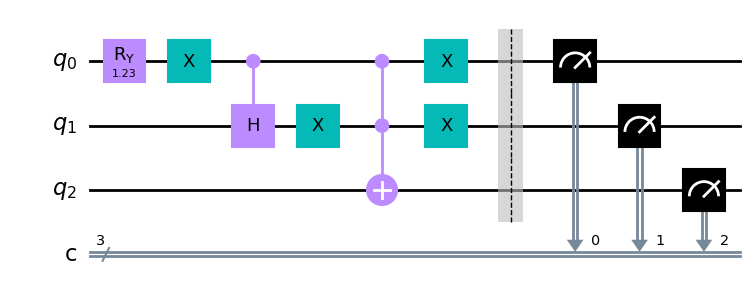

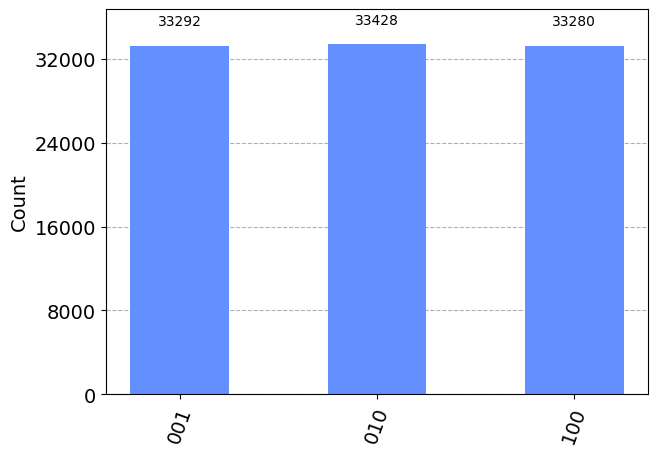

In [2]:
print("VERSION 1:")
qc = QuantumCircuit(3,3)

rot = 2* np.arcsin(1/np.sqrt(3))
qc.ry(rot,0)

qc.x(0)
qc.ch(0, 1)
    
qc.x(1)
qc.ccx(0, 1, 2)
qc.x(1)
    
qc.x(0)

qc.barrier()

qc.measure(range(3),range(3))
display(qc.draw('mpl'))

localSimulator = Aer.get_backend('qasm_simulator')
result = execute(qc, localSimulator, shots=100000).result()
counts = result.get_counts(qc)
plot_histogram(counts)

Esta es solo una de las formas de generar el estado $W$. Hay 2 variaciones del mismo submodulo que son las siguientes:

VERSION 2


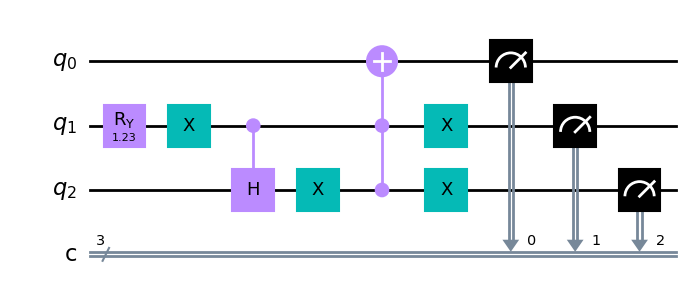

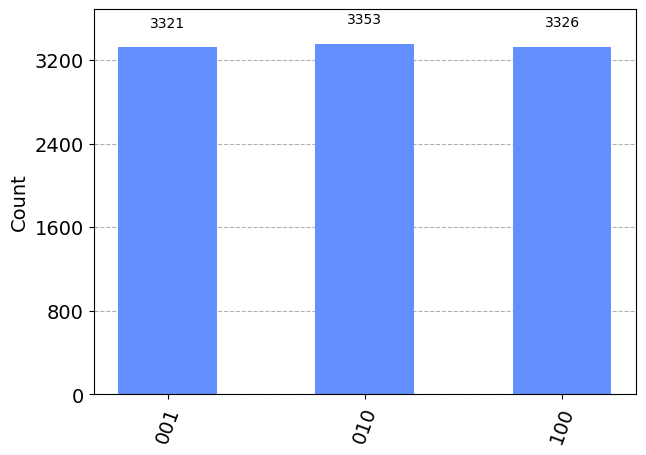

In [3]:
print('VERSION 2')
qc = QuantumCircuit(3,3)

rot = 2* np.arcsin(1/np.sqrt(3))
qc.ry(rot,1)

qc.x(1)
qc.ch(1, 2)
    
qc.x(2)
qc.ccx(1, 2, 0)
qc.x(2)
    
qc.x(1)

qc.measure(range(3),range(3))
display(qc.draw('mpl'))

localSimulator = Aer.get_backend('qasm_simulator')
result = execute(qc, localSimulator, shots=10000).result()
counts = result.get_counts(qc)
plot_histogram(counts)

VERSION 3:


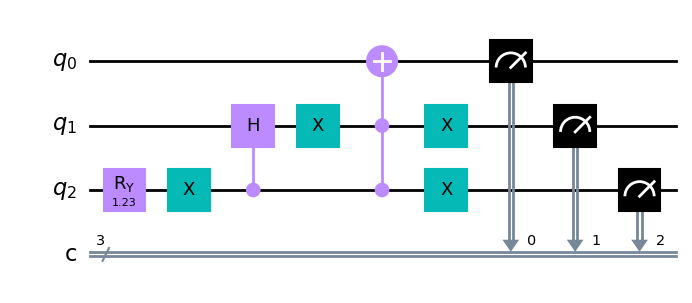

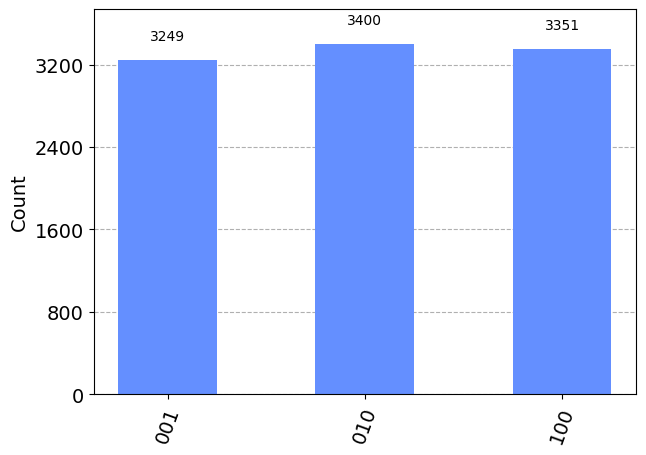

In [4]:
print("VERSION 3:")
qc = QuantumCircuit(3,3)

rot = 2* np.arcsin(1/np.sqrt(3))
qc.ry(rot,2)

qc.x(2)
qc.ch(2, 1)
    
qc.x(1)
qc.ccx(2, 1, 0)
qc.x(1)
    
qc.x(2)

qc.measure(range(3),range(3))
display(qc.draw('mpl'))

localSimulator = Aer.get_backend('qasm_simulator')
result = execute(qc, localSimulator, shots=10000).result()
counts = result.get_counts(qc)
plot_histogram(counts)

Llamaremos a estas tres versiones $M_1,M_2,M_3$ respectivamente. Por ahora, usemos solo $M_1$ para continuar desarrollando el algoritmo. Procederemos a ensamblar el submodulo $M_1^\dagger$, que nos permitira realizar uncomputing sobre el algoritmo.

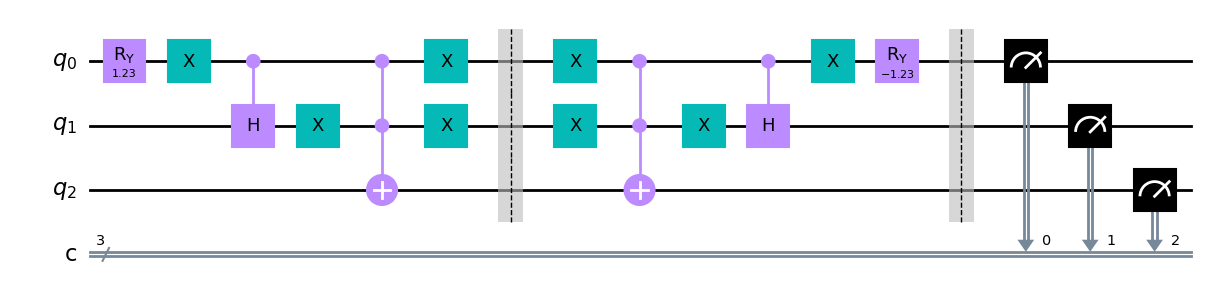

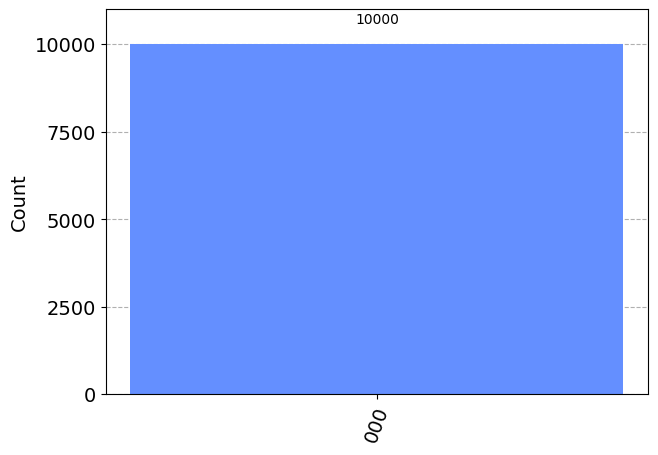

In [21]:
qc = QuantumCircuit(3,3)

rot = 2* np.arcsin(1/np.sqrt(3))
qc.ry(rot,0)

qc.x(0)
qc.ch(0, 1)
    
qc.x(1)
qc.ccx(0, 1, 2)
qc.x(1)
    
qc.x(0)

qc.barrier()

qc.x(0)

qc.x(1)
qc.ccx(0, 1, 2)
qc.x(1)

qc.ch(0, 1)
qc.x(0)
qc.ry(-rot,0)


qc.barrier()

qc.measure(range(3),range(3))
display(qc.draw('mpl'))

localSimulator = Aer.get_backend('qasm_simulator')
result = execute(qc, localSimulator, shots=10000).result()
counts = result.get_counts(qc)
plot_histogram(counts)

Ahora viene el paso mas importante. Debemos crear en medio de los modulo $M_1$ y $M_1^\dagger$ un modulo oraculo. Para entender este oraculo, hay que remitirnos a la funcion de los oraculos en los modelos de consulta cuantica. Si no conocen como funciona, puede buscar bibliografia. Es el mismo modelo en el que se basan los algoritmo de Deutsch-Jozsa y el de Bernstein-Vazirani. Resumidamente, el oraculo aplicara un cambio de fase al estado de entrada siempre que representen una solucion correcta. En nuestro caso, el estado que represente haber elegido la puerta correcta.

Empezemos creado un oraculo que marque el estado $|001 \rangle$.

ALGORITMO USANDO M1


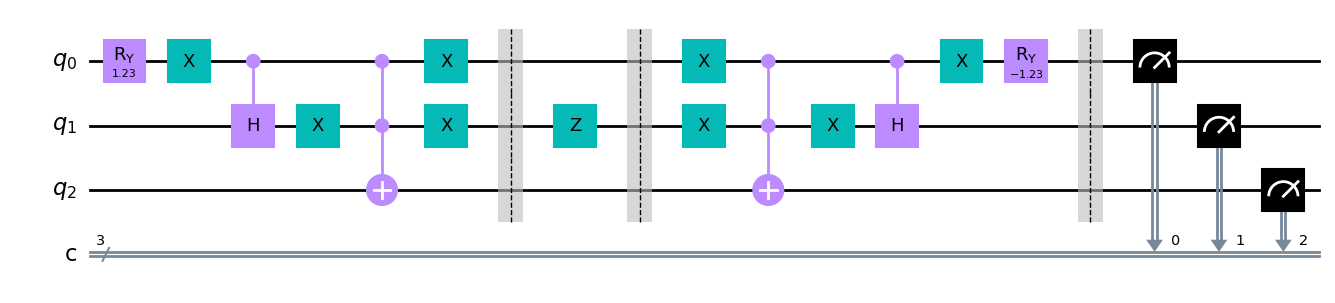

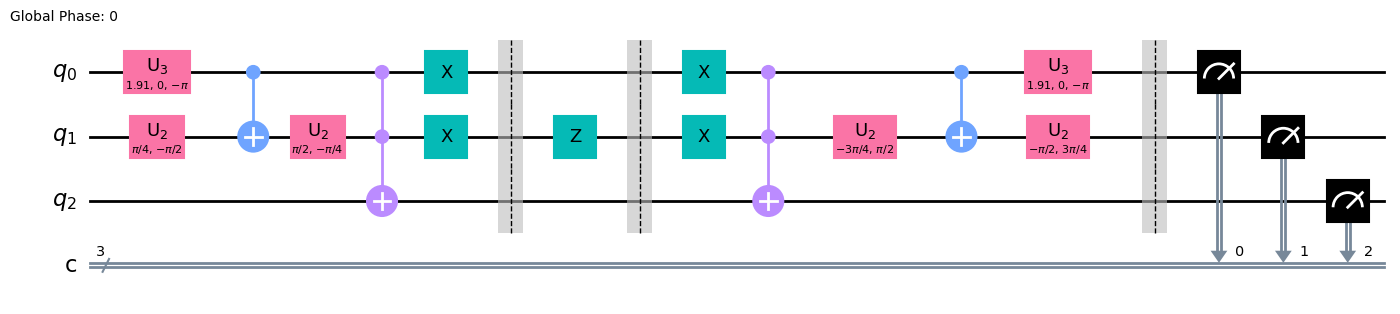

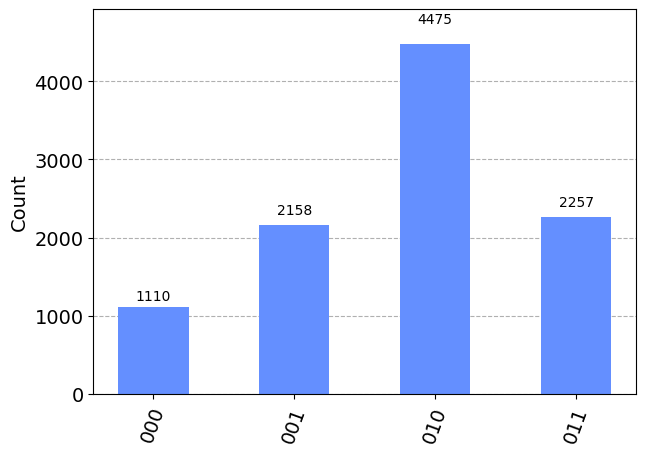

In [95]:
print('ALGORITMO USANDO M1')
#0 = 001; 1 = 010; 2=100
ESTADO_MARCADO = 1

qc = QuantumCircuit(3,3)

#M1
rot = 2* np.arcsin(1/np.sqrt(3))
qc.ry(rot,0)

qc.x(0)
qc.ch(0, 1)
    
qc.x(1)
qc.ccx(0, 1, 2)
qc.x(1)
    
qc.x(0)

#ORACULO
qc.barrier()
qc.z(ESTADO_MARCADO)
qc.barrier()

#M2
qc.x(0)

qc.x(1)
qc.ccx(0, 1, 2)
qc.x(1)

qc.ch(0, 1)
qc.x(0)
qc.ry(-rot,0)


qc.barrier()

qc.measure(range(3),range(3))
display(qc.draw('mpl'))

localSimulator = Aer.get_backend('qasm_simulator')
qc = transpile(qc,localSimulator,optimization_level=3)
display(qc.draw('mpl'))

result = execute(qc,localSimulator, shots=10000).result()
counts = result.get_counts(qc)
plot_histogram(counts)

A simple vista, pareciera que nuestro algoritmo da resultados exitosos. Con un 88%, nos daría como solución cual es la puerta correcta. Pero el problema viene cuando el estado marcado por el oraculo cambio.

Les recomiendo ir al codigo de arriba, y cambiar el valor de $ESTADO\_MARCADO$ por $1$ y luego por $2$. Veran entonces que el comportamiento del mismo cambia negativamente.

Resumidamente,el algoritmo deja de funcionar. A que se debe esto? Se debe a la version de preparacion de estado $W$ que estamos usando,concretamente,$M_1$. El algoritmo de resolucion que utiliza a $M_1$ funciona unicamente cuando el oraculo marca el estado $|001\rangle$.

Para que el algoritmo funcione cuando el oraculo marca los estados $|010\rangle$ y $|100\rangle$ se deben $M_2$ y $M_3$.

ALGORITMO USANDO M2


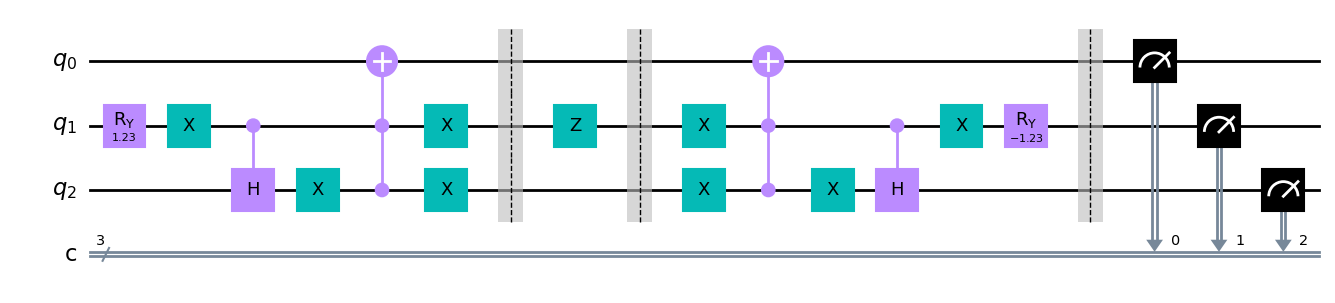

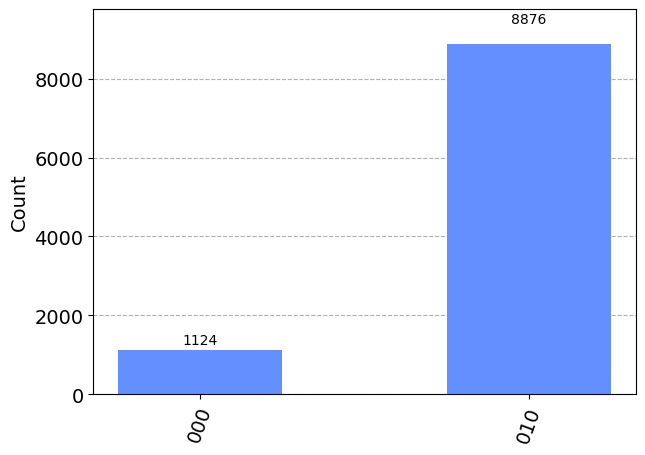

In [23]:
print('ALGORITMO USANDO M2')
#ALGORITMO CON M2
qc = QuantumCircuit(3,3)

rot = 2* np.arcsin(1/np.sqrt(3))
qc.ry(rot,1)

qc.x(1)
qc.ch(1, 2)
    
qc.x(2)
qc.ccx(1, 2, 0)
qc.x(2)
    
qc.x(1)

#ORACULO
qc.barrier()
qc.z(1)
qc.barrier()

qc.x(1)

qc.x(2)
qc.ccx(1, 2, 0)
qc.x(2)

qc.ch(1, 2)
qc.x(1)
qc.ry(-rot,1)


qc.barrier()

qc.measure(range(3),range(3))
display(qc.draw('mpl'))

localSimulator = Aer.get_backend('qasm_simulator')
result = execute(qc, localSimulator, shots=10000).result()
counts = result.get_counts(qc)
plot_histogram(counts)

ALGORITMO USANDO M3


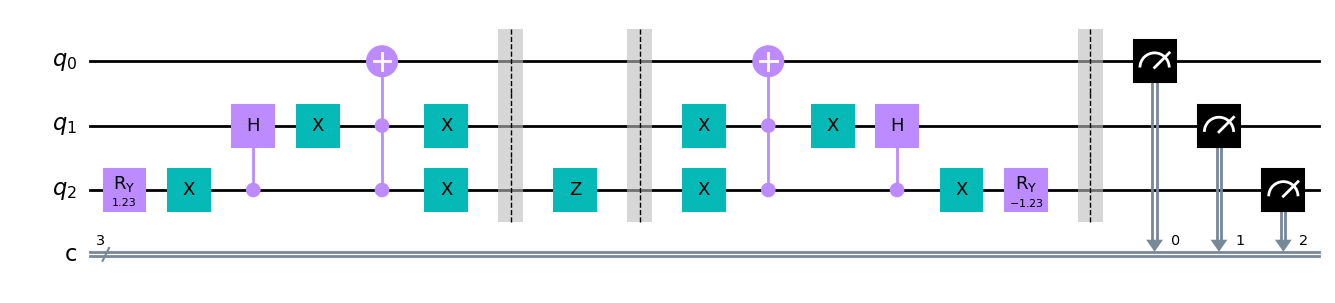

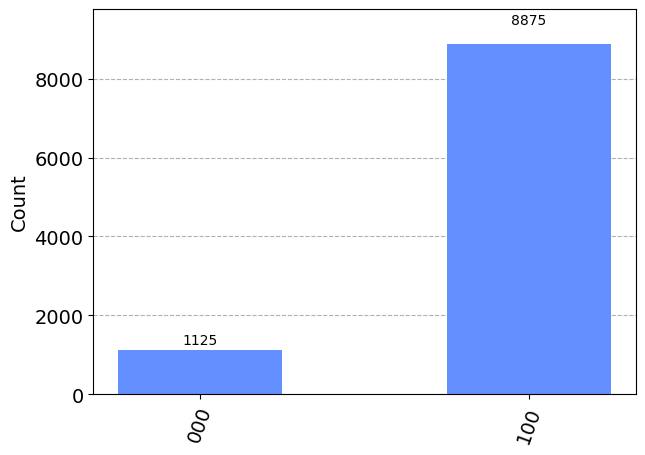

In [24]:
print('ALGORITMO USANDO M3')
ESTADO_MARCADO = 2

# ALGORITMO CON M3
qc = QuantumCircuit(3,3)

rot = 2* np.arcsin(1/np.sqrt(3))
qc.ry(rot,2)

qc.x(2)
qc.ch(2, 1)
    
qc.x(1)
qc.ccx(2, 1, 0)
qc.x(1)
    
qc.x(2)

#ORACULO
qc.barrier()
qc.z(ESTADO_MARCADO)
qc.barrier()

qc.x(2)

qc.x(1)
qc.ccx(2, 1, 0)
qc.x(1)

qc.ch(2, 1)
qc.x(2)
qc.ry(-rot,2)


qc.barrier()

qc.measure(range(3),range(3))
display(qc.draw('mpl'))

localSimulator = Aer.get_backend('qasm_simulator')
result = execute(qc, localSimulator, shots=10000).result()
counts = result.get_counts(qc)
plot_histogram(counts)

## Planteando el problema de monty hall de forma cuantica.

Podemos plantear el problema de la siguiente forma. Definimos una funcion $f(x)=y$,donde $x,y \in \{001,010,100\}$. Esta funcion representa la primera decision de una de las posibles tres puertas, siendo $x$ la cadena de caracteres que representa esta eleccion. La salida $y$ representa cual puerta es la que luego abre Monty...
Supongamos que elegimos la puerta de la izquierda y luego Monty decide abrir la puerta del medio para,posteriormente, darnos la opcion de cambiar a la puerta restante. Este proceso descrito puede representarse como $f(100)=010$.

Lo mas importante es la funcion $g(x)$, descrita a continuacion. Esta funcion representa la ultima decision que tomamos de si cambiar o quedarnos en la misma puerta. Tiene la forma de $g(x)=z,$ donde $ x \ in \{001,010,100\} - {y}, z \in \{0,1\}$. Es decir, x representa la eleccion de si quedarse en la puerta actual o cambiarse. Notemos que el rango de valores de $x$ no incluye a $y$. Esto es porque $y$ es la salida de la funcion $f(x)$, lo que significa que representa a la puerta que Monty abrio y ya no puede ser elegida. La salida $z$ representa si,finalmente, ganamos o no el juego.

La resolucion clasica de este problema es siempre cambiar de puerta ya que tenemos una probabilidad aproximada de $66\%$ de ganar en ese caso. Pero ya vimos que el algoritmo descrito en el capitulo anterior puede permitirnos descubrir cual es la puerta correcta con una probabilidad aproximada de $88\%$. Podriamos crear una funcion $g'(x)$ que se pueda embeber dentro de $g(x)$ de la siguiente manera:

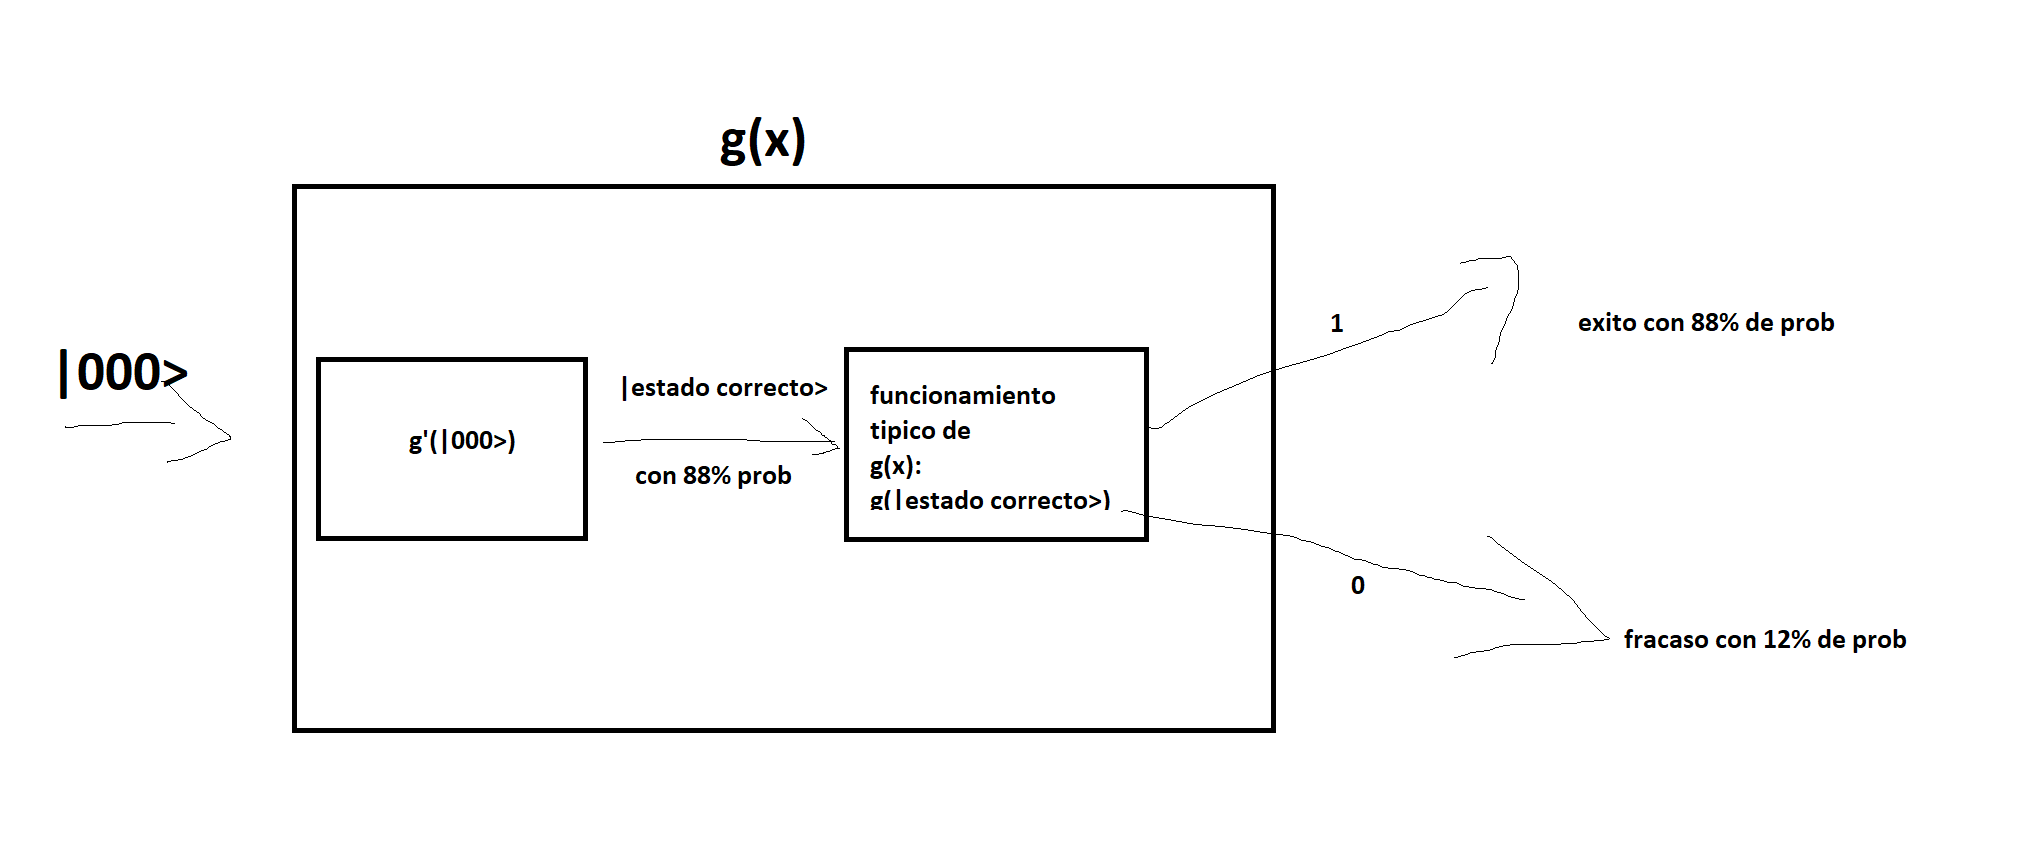

In [25]:
from PIL import Image
img = Image.open(r'C:/Users/54299/Desktop/Facultad/4to anio/Cursos/Escuela de Computacion Cuantica en Español 2023/diagramas.png')
display(img)

El mayor problema para garantizar esto es que la probabilidad de $88\%$ depende de armar $g'(x$) con los modulo $M_x$ y $M_x^\dagger$ correcto.Como se vio en la primera seccion, si no se eligen los modulos correctamente, el algoritmo pierde gran parte de su probabilidad de exito. Desarrollare un capitulo tratando de solucionar ese problema a continuacion.

## Variantes del algoritmo anterior

Una opcion para solucionar la necesidad de saber el $M_x$ y $M_x\dagger$ que debe usarse, es la siguiente:

En vez de usar $M_x\dagger$ para hacer uncomputing con el estado $W$ marcado por el oraculo, usaremos simplemente una barrera de compuertas $H$. Con esto, el algoritmo funciona indiferentemente del $M_x$ que se use(recordemos que $M_x\dagger$ no se usa mas por que se reemplaza por los $H$. La desventaja de esta solucion es que la fiabilidad del algoritmo baja de un $88%$ a un $75\%$. Aun asi, esta fiabilidad es mayor al $66\%$ de la solucion clasica.

Para probar esta variacion, cambien la variable ESTADO_MARCADO por valores 0,1,2 para ver que funciona todo correctamente.

ALGORITMO USANDO M3 Y BARRERAS DE H PARA UNCOMPUTING


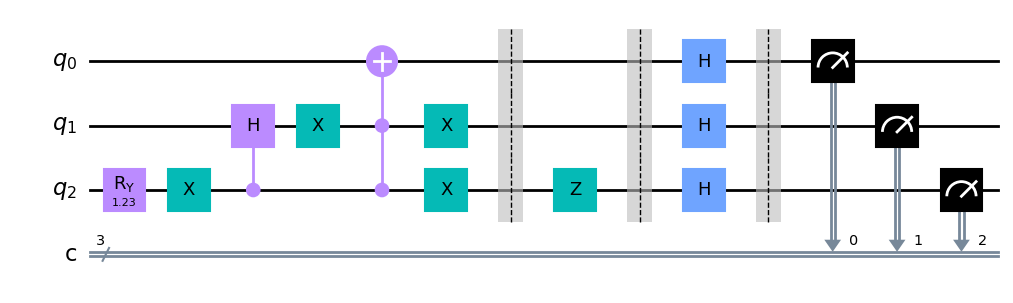

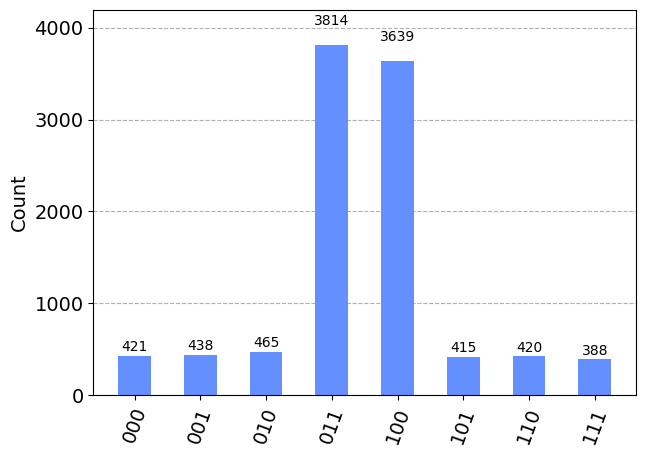

In [79]:
print('ALGORITMO USANDO M3 Y BARRERAS DE H PARA UNCOMPUTING')
ESTADO_MARCADO = 2

# ALGORITMO CON M3
qc = QuantumCircuit(3,3)

rot = 2* np.arcsin(1/np.sqrt(3))
qc.ry(rot,2)

qc.x(2)
qc.ch(2, 1)
    
qc.x(1)
qc.ccx(2, 1, 0)
qc.x(1)
    
qc.x(2)

#ORACULO
qc.barrier()
qc.z(ESTADO_MARCADO)
qc.barrier()

#---BARRERA H---
qc.h(range(3))
#---BARRERA H---



qc.barrier()

qc.measure(range(3),range(3))
display(qc.draw('mpl'))

localSimulator = Aer.get_backend('qasm_simulator')
result = execute(qc, localSimulator, shots=10000).result()
counts = result.get_counts(qc)
display(plot_histogram(counts))

Una segunda variacion involucra mezclar tanto $M_x\dagger$ como la barrera de compuertas $H$. Esta variación permite una probabilidad de exito del $79\%$, es decir, una mejora del $4\%$ respecto a la prinera variación.

ALGORITMO USANDO M3 Y M3Dagger + BARRERAS DE H PARA UNCOMPUTING


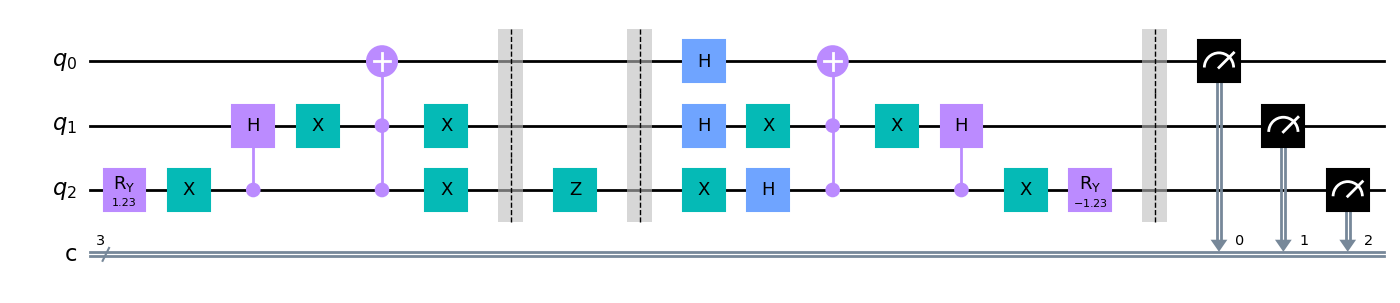

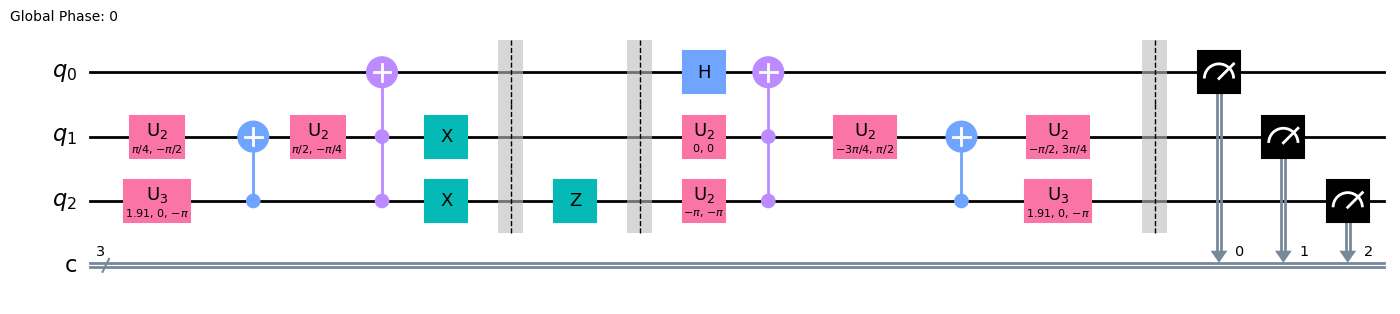

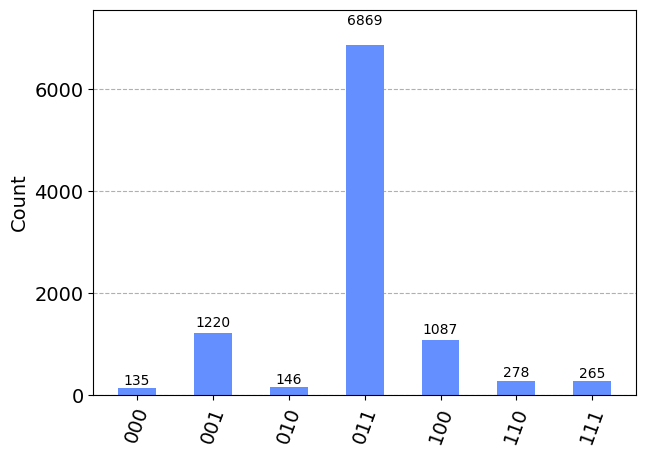

In [96]:
print('ALGORITMO USANDO M3 Y M3Dagger + BARRERAS DE H PARA UNCOMPUTING')
ESTADO_MARCADO = 2

# ALGORITMO CON M3
qc = QuantumCircuit(3,3)

rot = 2* np.arcsin(1/np.sqrt(3))
qc.ry(rot,2)

qc.x(2)
qc.ch(2, 1)
    
qc.x(1)
qc.ccx(2, 1, 0)
qc.x(1)
    
qc.x(2)

#ORACULO
qc.barrier()
qc.z(ESTADO_MARCADO)
qc.barrier()

qc.x(2)

#---BARRERA H---
qc.h(range(3))
#---BARRERA H---

qc.x(1)
qc.ccx(2, 1, 0)
qc.x(1)

qc.ch(2, 1)
qc.x(2)
qc.ry(-rot,2)



qc.barrier()

qc.measure(range(3),range(3))
display(qc.draw('mpl'))

localSimulator = Aer.get_backend('qasm_simulator')
qc = transpile(qc,localSimulator,optimization_level=3)
display(qc.draw('mpl'))

result = execute(qc, localSimulator, shots=10000).result()
counts = result.get_counts(qc)
display(plot_histogram(counts))